## Evidence Retrieval Model

Import libraries for loading the pretrained model, as well as replacing the weights by the finetuned version.

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import string
import torch.nn.functional as F

Load the pretrained model, replace the weights by the finetuned version, and load it into GPU (if there is one) for faster inference.

In [ ]:
## Use these code to load the finetuned model
## Remember to upload the model to colab space if you are working on Colab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.load_state_dict(torch.load('minilm-finetune-50000.ckpt', map_location=device))
model = model.to(device)

A helper function to preprocess sentence (not really useful)

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.replace('\n', '').replace('\t', '')
    return sentence

A function that takes in claims, candidate sentences and output a ranked version of the sentences based on their relevance to the claim.

In [ ]:
def rank_sentences_based_on_relevance(claim, sentences, model, tokenizer, device, batch_size=128):
  '''
  Input
  claim: a string
  sentences: a list of strings
  model: the embedding model used for the ranking
  tokenizer: the tokenizer used for the ranking
  Returns
  sorted_sentences: the list of sentences, sorted by relevance
  '''

  preprocessed_claim = preprocess_sentence(claim)
  preprocessed_sentences = [preprocess_sentence(sentence) for sentence in sentences]

  similarities = []

  with torch.no_grad():
    tokneized_claim = tokenizer(claim, padding=True, truncation=True, return_tensors="pt").to(device)
    claim_tensor = model(**tokneized_claim).pooler_output

  for i in range(0, len(preprocessed_sentences), batch_size):
    batch_sentences = preprocessed_sentences[i:i + batch_size]
    tokenized_sentences = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
      model.eval()
      sentences_tensors = model(**tokenized_sentences).pooler_output
      # Computing similarity for each sentence in the batch
      for sentence_tensor in sentences_tensors:
        similarity = F.cosine_similarity(claim_tensor, sentence_tensor.unsqueeze(0))
        similarities.extend(similarity.tolist())

  similarity_with_index = list(enumerate(similarities))
  similarity_with_index.sort(key=lambda x: x[1], reverse=True)

  sorted_sentences = [sentences[i] for i, _ in similarity_with_index]
  sorted_similarities = [similarity for _, similarity in similarity_with_index]

  return sorted_sentences, sorted_similarities

DEMOs of using the function above:

In [ ]:
claim = "Universities have high expenses."
evidences = ["Basketball involves competition and tactics", "Football is very popular", "Jupiter has a lot of moons", "Universities are very expensive in the UK"]

ranked_sentences, _ = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
print(ranked_sentences)

['Universities are very expensive in the UK', 'Football is very popular', 'Jupiter has a lot of moons', 'Basketball involves competition and tactics']


In [ ]:
claim = "Basketball can make you exercise."
evidences = ["Basketball is a sport, and it gets very competitive", "Football is very popular", "Jupiter has a lot of moons", "Universities are very expensive in the UK"]

ranked_sentences, _ = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
print(ranked_sentences)

['Basketball is a sport, and it gets very competitive', 'Football is very popular', 'Jupiter has a lot of moons', 'Universities are very expensive in the UK']


In [ ]:
claim = "In the solar system, Jupyter is the largest planet, it looks like a ball."
evidences = ["Basketball is a sport, and it gets very competitive", "Football is very popular", "Jupiter has a lot of moons", "Universities are very expensive in the UK"]

ranked_sentences, _ = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
print(ranked_sentences)

(['Jupiter has a lot of moons', 'Basketball is a sport, and it gets very competitive', 'Football is very popular', 'Universities are very expensive in the UK'], [0.6000271439552307, 0.34500646591186523, 0.3136049509048462, 0.16730836033821106])


Visualisation: Bar plot to show similarity scores of the sentences

['Universities are very expensive in the UK', 'Football is very popular', 'Jupiter has a lot of moons', 'Basketball involves competition and tactics']


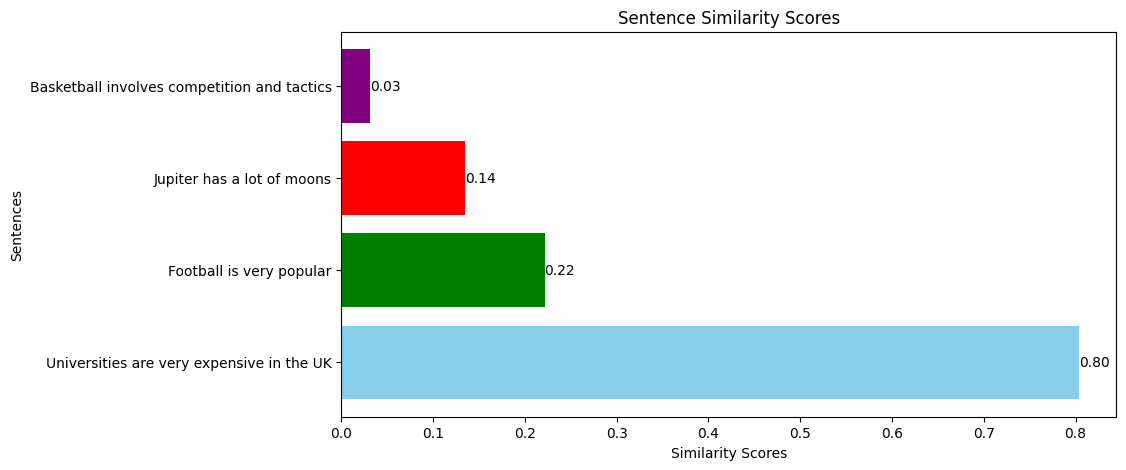

In [ ]:
import matplotlib.pyplot as plt

# Define a visualisation function to show the similarity scores of the sentences and how relevant each sentence is to the claim
def visualize_similarity_scores(sentences, similarities):
    colors = ['skyblue', 'green', 'red', 'purple']  # Modify this list based on your preferred colors
    plt.figure(figsize=(10,5))
    for i in range(len(sentences)):
        plt.barh(sentences[i], similarities[i], color=colors[i])
        plt.text(similarities[i], i, f'{similarities[i]:.2f}', va='center')
    plt.xlabel('Similarity Scores')
    plt.ylabel('Sentences')
    plt.title('Sentence Similarity Scores')
    plt.show()

claim = "Universities have high expenses."
evidences = ["Basketball involves competition and tactics", "Football is very popular", "Jupiter has a lot of moons", "Universities are very expensive in the UK"]

ranked_sentences, sorted_similarities = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
print(ranked_sentences)

# Use the function after calculating similarities
visualize_similarity_scores(ranked_sentences, sorted_similarities)

Some additional libraries.

In [ ]:
!pip install tqdm pandas wikipedia openai
!pip install datasets
!pip install fireworks chromadb
!pip install python-dotenv
!pip install --upgrade fireworks-ai

import fireworks.client

import os
import dotenv
import chromadb
import json
from tqdm.auto import tqdm
import pandas as pd
import random
from tqdm import tqdm
import wikipedia
import spacy
nlp = spacy.load("en_core_web_sm")
#True labels
from matplotlib import pyplot as plt
import seaborn as sns

The code below sets up the fireworks API: an API that hosts Mistral-7b-instruct-4k, the LLM we are using. It also sends a testing prompt for the LLM.

In [ ]:
# you can set envs using Colab secrets
dotenv.load_dotenv()

fireworks.client.api_key = # Your Fireworks API key here

def get_completion(prompt, model=None, max_tokens=50):
    fw_model_dir = "accounts/fireworks/models/"
    if model is None:
        model = fw_model_dir + "mistral-7b-instruct-4k"
    else:
        model = fw_model_dir + model
    completion = fireworks.client.Completion.create(
        model=model,
        prompt=prompt,
        max_tokens=max_tokens,
        temperature=0
    )
    return completion.choices[0].text

# Test LLM Api

mistral_llm = "mistral-7b-instruct-4k"

prompt = """[INST]
Given the following wedding guest data, write a very short 3-sentences thank you letter:

{
  "name": "John Doe",
  "relationship": "Bride's cousin",
  "hometown": "New York, NY",
  "fun_fact": "Climbed Mount Everest in 2020",
  "attending_with": "Sophia Smith",
  "bride_groom_name": "Tom and Mary"
}

Use only the data provided in the JSON object above.

The senders of the letter is the bride and groom, Tom and Mary.
[/INST]"""

get_completion(prompt, model=mistral_llm, max_tokens=150)

" Dear John Doe,\n\nWe, Tom and Mary, would like to extend our heartfelt gratitude for your attendance at our wedding. It was a pleasure to have you there, and we truly appreciate the effort you made to be a part of our special day.\n\nWe were thrilled to learn about your fun fact - climbing Mount Everest is an incredible accomplishment! We hope you had a safe and memorable journey.\n\nThank you again for joining us on this special occasion. We hope to stay in touch and catch up on all the amazing things you've been up to.\n\nWith love,\n\nTom and Mary"

# Step 0: Load dataset


In [ ]:
from datasets import load_dataset

# dataset = load_dataset("fever", "v1.0)

# Only load part of the data to save RAM
X_train = load_dataset("fever", "v1.0", split='train[:10000]')
X_valid = load_dataset("fever", "v1.0", split='labelled_dev[:10000]')
X_test = load_dataset("fever", "v1.0", split='paper_test[:10000]')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for fever contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fever
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Visualisation: Distribution of True Labels from the loaded FEVER Dataset

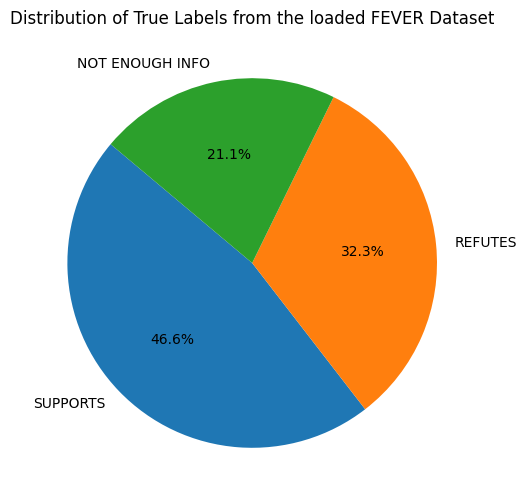

In [ ]:
from datasets import concatenate_datasets

# Concatenate the datasets
full_fever_subset = concatenate_datasets([X_train, X_valid, X_test])

# Convert to pandas DataFrame for easier manipulation and visualization
import pandas as pd
full_fever_df = full_fever_subset.to_pandas()

# Now, plotting the distribution of true labels
import matplotlib.pyplot as plt

true_labels_counts = full_fever_df['label'].value_counts()

plt.figure(figsize=(8, 6))
true_labels_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of True Labels from the loaded FEVER Dataset')
plt.ylabel('')  # This hides the 'label' ylabel to make the pie chart cleaner
plt.show()

# Step 1: Retrieve documents based on query

This function accepts a claim as its input, and output the keywords extracted from the claim. As discussed, we have used Named Entity Recognition + LLM to extract keywords.

In [ ]:
# name entity recognition and LLM
def claim_extract(claim):
    prompt_key = f"""[INST]
    Given the following claim, extract a query phrase to search on wikipedia for most relevant information:

    CLAIM: {claim}

    Extract ONE entity name or ONE phrase that when used to search on wikipedia, returns the most informative page on the claim.
    Return ONLY the name or the phrase. DO NOT return anything else.
    [/INST]"""

    doc = nlp(claim)
    entities = [(entity.text, entity.label_) for entity in doc.ents] # NER happens here
    keyword_1 = [entity[0] for entity in entities]
    keyword_2=get_completion(prompt_key, max_tokens=150) # LLM extraction happens here
    keyword_2=keyword_2.strip().replace('"', '').split(', ')
    keyword=keyword_1+keyword_2
    keyword=list(set(keyword))
    return keyword

# Test
claim="Jason Bourne removed Riz Ahmed from the movie's cast."
print(claim)
print(claim_extract(claim))

Jason Bourne removed Riz Ahmed from the movie's cast.
['Riz Ahmed', 'Jason Bourne']


Visualisation: (a)Word cloud to show the extracted keywords and (b) Word cloud to show all claims in the fever dataset

Grease had bad reviews.
['Grease']


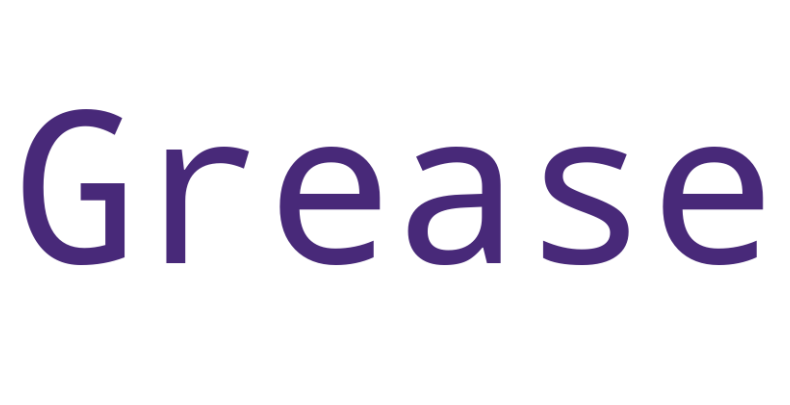

In [ ]:
# word cloud to visualize the keywords.

!pip install wordcloud
from wordcloud import WordCloud

def visualize_keywords(keywords):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

claim="Grease had bad reviews."
print(claim)
keywords = claim_extract(claim)
print(keywords)

# Use the function after extracting keywords
visualize_keywords(keywords)

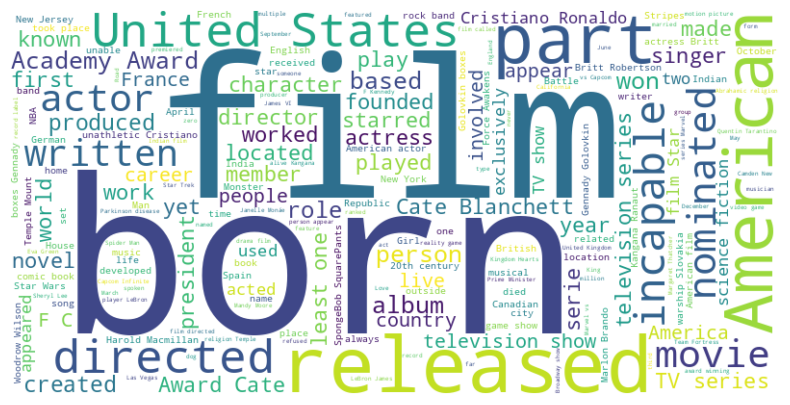

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all claims into a single string
all_claims = ' '.join(full_fever_df['claim'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_claims)

# Display the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Step 2: Retrieve text based on query from document

By using the wikipedia api, we can search for pages and retrieve the top page from a search query. The function below accepts a claim as its input, extract keywords using the function above, and do the search and return the full page.

In [ ]:
!pip install requests
import requests

def retrival_return_pages(claim):
    # URL for the Wikipedia API
    base_url = "https://en.wikipedia.org/w/api.php"

    keywords=claim_extract(claim)

    content=[]
    for search_query in keywords:
        # Parameters for searching Wikipedia
        search_params = {
            'action': 'query',
            'format': 'json',
            'list': 'search',
            'srsearch': search_query,
            'srlimit': 1,  # Limiting the search results to the most relevant one
        }

        # Sending the GET request to search Wikipedia
        search_response = requests.get(base_url, params=search_params)
        search_data = search_response.json()

        # Extracting the title of the most relevant page
        if search_data['query']['search']:
            title = search_data['query']['search'][0]['title']
        else:
            continue

        # Parameters for getting the content of the page
        content_params = {
            'action': 'query',
            'format': 'json',
            'titles': title,
            'prop': 'extracts',
            'explaintext': True,
            'exsectionformat': 'wiki'
        }

        # Sending the GET request to get the full content of the page
        content_response = requests.get(base_url, params=content_params)
        content_data = content_response.json()

        # Extracting page ID to access the content
        page_id = next(iter(content_data['query']['pages']))

        # Accessing the content
        content.append(content_data['query']['pages'][page_id].get('extract', 'Content not available.'))

    if content==[]:
        content.append('No content found')

    return content

# Test
claim="Jason Bourne removed Riz Ahmed from the movie's cast."
r=retrival_return_pages(claim)

Visualisation: Pie chart to visualize the distribution of content across different Wikipedia pages

In [ ]:
# def visualize_content_distribution(content):
#     lengths = [len(c) for c in content]
#     labels = ['Page '+str(i+1) for i in range(len(content))]
#     plt.figure(figsize=(10,5))
#     plt.pie(lengths, labels=labels, autopct='%1.1f%%')
#     plt.title('Distribution of Content Across Wikipedia Pages')
#     plt.show()

# claim="Jason Bourne removed Riz Ahmed from the movie's cast."
# content = search_wikipedia_and_get_content(claim)
# print(content)

# # Use the function after retrieving content
# visualize_content_distribution(content)

Code below is for preprocessing text. Not used in current version.

In [ ]:
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
import re

def preprocess_text(text):
    # Tokenize into sentences
    sentences = sent_tokenize(text)
    sentences=[re.sub(r'[^\w\s]', '', sentence.lower()) for sentence in sentences]

    # Tokenize into words, remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    preprocessed_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [word for word in words if word not in stop_words]
        preprocessed_sentences.append(' '.join(words))

    return preprocessed_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The function below uses the sent_tokenizer from nltk to split an article into sentences. Then, it uses the ranker implemented above to rank sentences based on relevance.

In [ ]:
# We need to implement a model such that given claim and content, it retrieves the most relevant information
# For now, return the whole page

## Old implementation using TF-IDF
# def retrival_relevant_sentences(claim, content,num):
#     '''
#     content : wiki pages
#     claim: The claim
#     num: number of sentences you want to retrieve
#     '''
#     # Preprocess document and claim
#     preprocessed_content = preprocess_text(content)
#     preprocessed_claim = preprocess_text(claim)  # Assuming claim is a single sentence

#     # Calculate TF-IDF scores
#     vectorizer = TfidfVectorizer()
#     tfidf_matrix = vectorizer.fit_transform(preprocessed_content)

#     # Calculate cosine similarity
#     claim_vector = vectorizer.transform(preprocessed_claim)
#     similarity_scores = cosine_similarity(claim_vector, tfidf_matrix)

#     # Get index of most relevant sentence
#     indices = np.argsort(similarity_scores)[0][-num:]

#     # Retrieve most relevant sentence
#     content_sent=sent_tokenize(content)
#     most_relevant_sentence = [content_sent[i] for i in indices]

#     return most_relevant_sentence

def retrival_relevant_sentences(claim, content, num):
    '''
    content : wiki pages
    claim: The claim
    num: number of sentences you want to retrieve
    '''
    content_sent = sent_tokenize(content)
    evidences = [preprocess_sentence(s) for s in content_sent]

    ranked_sentences, _= rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
    return ranked_sentences[:num]

all_content=retrival_return_pages(claim)
for content in all_content:
  print(retrival_relevant_sentences(claim, content, 5))
  print(len(retrival_relevant_sentences(claim, content, 5)))

['He also has upcoming roles in the films Fingernails and Relay.', "He found that most of the people dealt with abandonment issues, and attempted to replicate this in Rick's abusive relationship with Lou.In 2016, he appeared in Rogue One, the first film in the new Star Wars anthology films as Bodhi Rook, a defected imperial pilot.", 'The film co-stars Olivia Cooke as his girlfriend, and Paul Raci as the leader of a Deaf retreat.', 'He went on to play Carlton Drake in the superhero film Venom (2018) and a drummer who loses his hearing in the drama film Sound of Metal (2019).', 'He had his break-out role in Nightcrawler (2014), which led to roles in the 2016 big-budget films Jason Bourne and Rogue One.']
5
['When Delta found Bourne after killing his way through the North Vietnamese, he simply killed Bourne in the jungles of Tam Quan.', "The killing of an art dealer dredges up snatches of Jason Bourne's impaired memory, in particular the murder of a young woman who entrusted him with a st

# Step 3: RAG

The function `prompt_rag(claim,retrived_sentences)` takes in a claim and retrieved sentences (in our case, these are the top 5 relevant sentences from the wiki article) and call LLM to query for result (SUPPORT, REFUTE or NOT ENOUGH INFO).

The function `RAG_1(claim, verbose=False)` integrates the entire workflow: retrieve article, rank sentences and call LLM. In the testing section, we just need to call this function for each instance of claim.

In [ ]:
# Given relevant sentences, ask LLM whether to refute or accept

def prompt_rag(claim,retrived_sentences):

    prompt =f'''<s>[INST] Use the INFORMATION provided, decide whether the CLAIM is supported, refuted or not enough information to verify.
    Reason through the verification process step by step, write your reasoning out load.
    At the end, clearly state whether the claim is supported, refuted or has not enough information.
    [/INST]
    </s>
    [INST]
    {{
        CLAIM: {claim}
    }}

    {{
        INFORMATION: {retrived_sentences}
    }}

    [/INST]'''

    reasons = get_completion(prompt, max_tokens=4096)

    prompt_c = f"""<s>[INST]
    Based on the given INFORMATION ONLY, decide whether the CLAIM is supported, refuted or not enough information to verify.
    Summarize the conclusion in one word: "SUPPORTS", "REFUTES" or "NOT ENOUGH INFO".
    [/INST]
    If the INFORMATION directly supports the claim, return: "SUPPORTS"
    If the INFORMATION directly refutes the claim, return: "REFUTES"
    If the INFORMATION does not refute nor support the claim return: "NOT ENOUGH INFO"
    </s>
    [INST]
    {{
        INFORMATION: {retrived_sentences}
    }}

    {{
        REASONING: {reasons}
    }}

    {{
        CLAIM: {claim}
    }}

    [/INST]"""

    return reasons, prompt_c


def RAG_1(claim, verbose=False):
  all_content=retrival_return_pages(claim)
  retrived_sentences=[]
  for content in all_content:
    r_sentences = retrival_relevant_sentences(claim,content,5)
    retrived_sentences.extend(r_sentences)
  retrived_sentences = [f"{i+1}. {sentence}" for i, sentence in enumerate(retrived_sentences)]
  reasons, prompt_c=prompt_rag(claim, retrived_sentences)
  result = get_completion(prompt_c, model=mistral_llm, max_tokens=4096)
  result = result.strip().replace('.', '')

  if verbose:
    print("Claim:", claim)
    print("Evidence retrieved:")
    for s in retrived_sentences:
      print('\t', s)
    print("Reasons:", reasons)
    print("Result:", result)

  return reasons, result

# Testing retrieval
claim=X_test[0]['claim']
reasons,result=RAG_1(claim, verbose=True)
claim=X_train[0]['claim']
reasons,result=RAG_1(claim, verbose=True)

Claim: Grease had bad reviews.
Evidence retrieved:
	 1. Grease may refer to:== Common uses ==Grease (lubricant), a type of industrial lubricantGrease, any petroleum  or fat (including cooking fat) that is a soft solid at room temperatureBrown grease, waste vegetable oil, animal fat, grease, etc.
	 2. that is recovered from a grease trapYellow grease, in rendering, used frying oils, or lower-quality grades of tallowHydrogenated vegetable oil, used as a replacement for lard and other rendered animal fatsVegetable shortening, used as a replacement for lard and other rendered animal fats=== Slang ===Grease, a euphemism, meaning, to bribe, as in "to grease someone's palm"Grease, a slang term for killing, as in "The mob has been known to grease anyone who gets in its way"Pomade, a hair styling wax== Arts, entertainment, and media ===== Theater ===Grease (musical), a 1971 musical play=== Films ===Grease (film), 1978 film made from the musical, starring John Travolta and Olivia Newton-JohnGrea

#Step 4: Baseline approach using LLM without RAG

The code below defines a function for the baseline approach: letting the LLM to only use its own "knowledge" to reach a conclusion.

In [ ]:
#ask LLM whether to refute or accept a claim based on their own knowledge


def prompt_self(claim):

    prompt = f"""[INST]
    Support or refute the following claim:

    {{
        CLAIM: {claim},
    }}

    Reason through the verification process step by step using your knowledge and write your reasoning out load.
    State clearly at the end if the claim is 'suported', 'refuted' or 'there is not enough information to verify the claim'.

    [/INST]"""

    reasons = get_completion(prompt, model=mistral_llm, max_tokens=4096)

    prompt_c = f"""[INST]
    Based on the INFORMATION ONLY, decide whether the CLAIM is supported, refuted or not enough information to verify.

    {{
        CLAIM: {claim},
    }}

    {{
        INFORMATION: {reasons},
    }}

    Only use the INFORMATION provided above to make your conclusion.
    Summarize the conclusion in one word: "SUPPORTS", "REFUTES" or "NOT ENOUGH INFO".
    If the INFORMATION supports the claim return: "SUPPORTS"
    If the INFORMATION refutes the claim return: "REFUTES"
    If the INFORMATION does not provide enough information to support or refute the claim, return "NOT ENOUGH INFO".
    [/INST]"""

    return prompt_c

result = get_completion(prompt_self(claim), model=mistral_llm, max_tokens=4096)

print()
claim=X_test[0]['claim']
print(f'claim: {claim}')
print("RESULT")
print(result)



claim: Grease had bad reviews.
RESULT
 NOT ENOUGH INFO.


#Step 5: Evaluating performance

The code below evaluates performance by calling LLM_only function on the first 546 instances from the test set.

In [ ]:
#Plotting performance of LLM alone

fever_test = pd.DataFrame(X_test)
fever_test=fever_test[:2500]
fever_test=fever_test.loc[:,['claim', 'label']]
fever_test=fever_test.drop_duplicates()
fever_test=fever_test[:800]


results = []
total = 0
correct = 0

progress_bar = tqdm(fever_test.iterrows(), total=len(fever_test.index),position=0)
for index, entry in progress_bar:
  claim = entry['claim']
  label = entry['label']
  result = get_completion(prompt_self(claim), model=mistral_llm, max_tokens=4096)
  result = result.strip().replace('"','').replace('.', '')
  results.append(result)
  if label == result:
    correct += 1
  total += 1
  progress_bar.set_postfix({'Accuracy': correct / total})

fever_test['LLM'] = results

# Calculate the accuracy of the LLM only method on the dataset
total_rows = len(fever_test)
equal_rows = len(fever_test[fever_test['label'] == fever_test['LLM']])
accuracy = (equal_rows / total_rows) * 100

print("LLM only method")
print('Number of roles with correct predictions: ',equal_rows)
print('Accuracy: ',accuracy)

fever_test

 72%|███████▏  | 576/800 [27:49<10:27,  2.80s/it, Accuracy=0.505]

Visualisation: Distribution of FEVER Test Data (True Labels)

In [ ]:
# Display the distribution of ground truth labels
ax = fever_test.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('FEVER Test Data (True Labels)', loc='center')

# Calculate the total number of instances
total = len(fever_test)

# Annotate the bars
for p in ax.patches:
    width = p.get_width()
    percentage = f'{100 * width/total:.2f}%'
    ax.text(width, p.get_y() + p.get_height()/2, f' {width} ({percentage})', va='center')

plt.savefig('Test data true labels.png')

Visualisation: Distribution of Predicted Labels by LLM only

In [ ]:
# Display the distribution of labels predicted by LLM only
ax = fever_test.groupby('LLM').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('Test Data LLM predicted labels', loc='center')

# Calculate the total number of instances
total = len(fever_test)

# Annotate the bars
for p in ax.patches:
    width = p.get_width()
    percentage = f'{100 * width/total:.2f}%'
    ax.text(width, p.get_y() + p.get_height()/2, f' {width} ({percentage})', va='center')

plt.savefig('LLM (only) predicted labels.png')

Visualisation: Confusion matrix with LLM only

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Extract true labels and predicted labels
# true_labels = fever_test['label']
# predicted_labels = fever_test['LLM']

# # Calculate confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

# # Print the confusion matrix
# print('Confusion Matrix (LLM only):')
# print(cm)

# # Plot the confusion matrix
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix (LLM only)')
# plt.show()




from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels and predicted labels
true_labels = fever_test['label']
predicted_labels = fever_test['LLM']

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])

# Print the confusion matrix
print('Confusion Matrix (LLM only):')
print(cm)


# Plot the confusion matrix
plt.figure(figsize=(10, 7))
# ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (LLM only)')

# Show the plot
plt.show()

Visualisation: Classification report and plot it as a heatmap (LLM only)

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract true labels and predicted labels
true_labels = fever_test['label']
predicted_labels = fever_test['LLM']

# Generate classification report
report = classification_report(true_labels, predicted_labels, labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], output_dict=True)

# Convert the report to dataframe
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(10,7))
sns.heatmap(report_df, annot=True, cmap='Blues')
plt.title('Classification Report Heatmap (LLM only)')
plt.show()

The code below evaluates performance by calling RAG_1 function on the first 546 instances from the test set.

In [ ]:
# Plotting performance of RAG system with LLM

fever_test = pd.DataFrame(X_test)
fever_test=fever_test[:2500]
fever_test=fever_test.loc[:,['claim', 'label']]
fever_test=fever_test.drop_duplicates()
fever_test=fever_test[:800]

results = []
total = 0
correct = 0

progress_bar = tqdm(fever_test.iterrows(), total=len(fever_test.index))
for index, entry in progress_bar:
  claim = entry['claim']
  label = entry['label']
  result = RAG_1(claim, verbose=True)[1]
  print("Label:", label)
  results.append(result)
  if label == result:
    correct += 1
  total += 1
  progress_bar.set_postfix({'Accuracy': correct / total})

fever_test['rag_1'] = results

# print(set(fever_test['label']))
# print(set(fever_test['rag_1']))
# print(set(fever_test['label'])==set(fever_test['rag_1']))

total_rows = len(fever_test)
equal_rows = len(fever_test[fever_test['label']== fever_test['rag_1']])
percentage = (equal_rows / total_rows) * 100
print('Accuracy using RAG: ',percentage)

fever_test

Visualisation: Distribution of Predicted Labels by LLM with RAG

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Group by the 'label' column and count the occurrences
label_counts = fever_test['rag_1'].value_counts()
label_counts = label_counts.reindex(['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']).fillna(0)

# Calculate total number of instances for percentage calculation
total = label_counts.sum()

# Plot the bar plot
ax = label_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

# Remove top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Annotate each bar with the count and the percentage of the total
for i in ax.patches:
    # Calculate percentage
    percentage = f'{(i.get_width() / total):.2%}'
    # Set the annotation text, which includes the count and percentage
    annotation_text = f'{int(i.get_width())} ({percentage})'
    # Place the annotation text on the bar
    ax.text(i.get_width() + total * 0.01, i.get_y() + 0.1, annotation_text, va='center', color='black')

# Set the title
ax.set_title('Test Data LLM with RAG Predicted Labels')

# Show the plot
plt.show()

In [ ]:
fever_test.to_csv('fever_test.csv', index=False)
from google.colab import files

files.download('fever_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(20):
  claim=fever_test.iloc[i,0]
  print('CLAIM: ', claim)
  reasons,result=RAG_1(claim)
  print('REASON: ',reasons)
  print('RESULT: ',result)
  print('--------------------------------------------------------------------------------------------------------------------------------------------')

Visualisation: Confusion Matrix (LLM with RAG Augmentation)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels and predicted labels
true_labels = fever_test['label']
predicted_labels = fever_test['rag_1']

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])

# Print the confusion matrix
print('Confusion Matrix (LLM with RAG Augmentation):')
print(cm)

# Plot the confusion matrix
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
# ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for LLM with RAG')

# Show the plot
plt.show()

Visualisation: Classification report and plot it as a heatmap (LLM with RAG Augmentation)

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Generate classification report
report = classification_report(true_labels, predicted_labels, labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], output_dict=True)

# Convert the report to dataframe
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(10,7))
sns.heatmap(report_df, annot=True, cmap='Blues')
plt.title('Classification Report Heatmap (LLM with RAG Augmentation)')
plt.show()